In [1]:
from glob import glob 
import numpy as np
import pandas as pd
import keras,cv2,os

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPool2D
import sklearn
from tqdm import tqdm_notebook,trange
import matplotlib.pyplot as plt
from torch.utils.data import Dataset

import gc
print(os.listdir("../input"))
data_trian_path  = '../input/train/'

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     print(filenames)



/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


['histopathologic-cancer-detection']


In [2]:

# %cd ..
# # %ls
# %pwd
# %cd working
# # %cd input
# %ls
# %pwd
# %ls

In [3]:
# loading data
full_train_df = pd.read_csv("../input/histopathologic-cancer-detection/train_labels.csv")
full_train_df.head()


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [4]:
%pwd
# %ls

'/kaggle/working'

In [5]:
# BASIC EDA

print("Train Size: {}".format(len(os.listdir('../input/histopathologic-cancer-detection/train/'))))
print("Test Size: {}".format(len(os.listdir('../input/histopathologic-cancer-detection/test/'))))


Train Size: 220025
Test Size: 57458


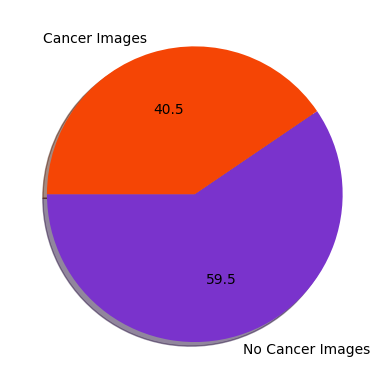

<Figure size 1600x1600 with 0 Axes>

In [6]:
labels_count = full_train_df.label.value_counts()

%matplotlib inline
plt.pie(labels_count, labels=['No Cancer Images', 'Cancer Images'], startangle=180, 
        autopct='%1.1f', colors=['#7a33cc','#f54505'], shadow=True)
plt.figure(figsize=(16,16))
plt.show()



In [7]:
# loading 70000 of data
SAMPLE_SIZE = 70000


train_path = '../input/histopathologic-cancer-detection/train/'
test_path = '../input/histopathologic-cancer-detection/test/'


df_negatives = full_train_df[full_train_df['label'] == 0].sample(SAMPLE_SIZE, random_state=42)
df_positives = full_train_df[full_train_df['label'] == 1].sample(SAMPLE_SIZE, random_state=42)


train_df = sklearn.utils.shuffle(pd.concat([df_positives, df_negatives], axis=0).reset_index(drop=True))

train_df.shape


(140000, 2)

In [8]:
# dataset class
class CreateDataset(Dataset):
    def __init__(self, df_data, data_dir = './', transform=None):
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_name,label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name+'.tif')
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [9]:
import torchvision.transforms as transforms

transforms_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.RandomVerticalFlip(p=0.4),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    # We the get the following mean and std for the channels of all the images
    #transforms.Normalize((0.70244707, 0.54624322, 0.69645334), (0.23889325, 0.28209431, 0.21625058))
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = CreateDataset(df_data=train_df, data_dir=train_path, transform=transforms_train)


In [10]:
from torch.utils.data import DataLoader, SubsetRandomSampler

batch_size = 128

# Percentage of training set to use as validation
valid_size = 0.1

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
# np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Create Samplers
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)


In [11]:
transforms_test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    #transforms.Normalize((0.70244707, 0.54624322, 0.69645334), (0.23889325, 0.28209431, 0.21625058))
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# creating test data
sample_sub = pd.read_csv("../input/histopathologic-cancer-detection/sample_submission.csv")
test_data = CreateDataset(df_data=sample_sub, data_dir=test_path, transform=transforms_test)

# prepare the test loader
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [12]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        # Convolutional and Pooling Layers
        self.conv1=nn.Sequential(
                nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=0),
                nn.BatchNorm2d(32),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        self.conv2=nn.Sequential(
                nn.Conv2d(in_channels=32,out_channels=64,kernel_size=2,stride=1,padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        self.conv3=nn.Sequential(
                nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        self.conv4=nn.Sequential(
                nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        self.conv5=nn.Sequential(
                nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        
        self.dropout2d = nn.Dropout2d()
        
        
        self.fc=nn.Sequential(
                nn.Linear(512*3*3,1024),
                nn.ReLU(inplace=True),
                nn.Dropout(0.4),
                nn.Linear(1024,512),
                nn.Dropout(0.4),
                nn.Linear(512, 1),
                nn.Sigmoid())
        
    def forward(self,x):
        """Method for Forward Prop"""
        x=self.conv1(x)
        x=self.conv2(x)
        x=self.conv3(x)
        x=self.conv4(x)
        x=self.conv5(x)
        #print(x.shape) <-- Life saving debugging step :D
        x=x.view(x.shape[0],-1)
        x=self.fc(x)
        return x

In [13]:
import torch
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')


CUDA is available!  Training on GPU ...


In [14]:
model = CNN()
print(model)

# Move model to GPU if available
if train_on_gpu: model.cuda()


CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 

In [15]:
# specify loss function 
import torch.optim as optim

criterion = nn.BCELoss()

# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.00015)

In [18]:
from sklearn.metrics import roc_auc_score


In [ ]:

n_epochs = 20

valid_loss_min = np.Inf

# keeping track of losses as it happen
train_losses = []
valid_losses = []
val_auc = []
test_accuracies = []
valid_accuracies = []
auc_epoch = []
for epoch in range(1, n_epochs+1):

    train_loss = 0.0
    valid_loss = 0.0
    model.train()
    for data, target in train_loader:

        if train_on_gpu:
            data, target = data.cuda(), target.cuda().float()
        target = target.view(-1, 1).float()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # Update Train loss and accuracies
        train_loss += loss.item()*data.size(0)
        print("done")
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda().float()
        # forward pass: compute predicted outputs by passing inputs to the model
        target = target.view(-1, 1).float()
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
        y_actual = target.data.cpu().numpy()
        y_pred = output[:,-1].detach().cpu().numpy()
        val_auc.append(roc_auc_score(y_actual, y_pred))        

    
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    valid_auc = np.mean(val_auc)
    auc_epoch.append(np.mean(val_auc))
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    print('Epoch: {} | Training Loss: {:.6f} | Validation Loss: {:.6f} | Validation AUC: {:.4f}'.format(
        epoch, train_loss, valid_loss, valid_auc))
    
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'best_model.pt')
        valid_loss_min = valid_loss